In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import time
plt.style.use('ggplot')
start_time = dt.datetime.now()
%matplotlib inline

In [2]:
%%time
data=pd.read_csv('applications data.csv')
data.shape

CPU times: user 579 ms, sys: 52 ms, total: 631 ms
Wall time: 634 ms


(1000000, 10)

In [3]:
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20170101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20170101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20170101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20170101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20170101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


# Data Preparation

In [4]:
#Convert Date
data['date']=pd.to_datetime(data.date.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))
data['dob_dt']=pd.to_datetime(data.dob.astype(str).apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:]))
#right alignment 
data['zip5']=data['zip5'].apply(lambda x:'{0:0>5}'.format(x))
#Fix frivolous Values
data.loc[data['address']=='123 MAIN ST','address']=data.loc[data['address']=='123 MAIN ST','record']\
.apply(lambda x:str(x)+'RECORD')
data.loc[data['ssn']==999999999,'ssn']=-data.loc[data['ssn']==999999999,'record']
data['ssn']=data['ssn'].apply(lambda x:'{0:0>9}'.format(x))
data.loc[data['dob']==19070626,'dob']=-data.loc[data.dob==19070626,'record']
data['dob']=data['dob'].apply(lambda x:'{0:0>8}'.format(x))
data.loc[data['homephone']==9999999999,'homephone']=-data.loc[data.homephone==9999999999,'record']
data['homephone']=data['homephone'].apply(lambda x:'{0:0>10}'.format(x))

In [5]:
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,dob_dt
0,1,2017-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0,1907-06-26
1,2,2017-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,1934-06-15
2,3,2017-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,1907-06-26
3,4,2017-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,1944-04-30
4,5,2017-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,1998-03-15


In [6]:
data['age_when_apply']=data['date'].dt.year-data['dob_dt'].dt.year

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   record          1000000 non-null  int64         
 1   date            1000000 non-null  datetime64[ns]
 2   ssn             1000000 non-null  object        
 3   firstname       1000000 non-null  object        
 4   lastname        1000000 non-null  object        
 5   address         1000000 non-null  object        
 6   zip5            1000000 non-null  object        
 7   dob             1000000 non-null  object        
 8   homephone       1000000 non-null  object        
 9   fraud_label     1000000 non-null  int64         
 10  dob_dt          1000000 non-null  datetime64[ns]
 11  age_when_apply  1000000 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 91.6+ MB


In [8]:
#Day of Week Target Encoding
data['dow']=data.date.apply(lambda x: calendar.day_name[x.weekday()])

In [9]:
# Separate the OOT
train_set=data[data.date<'2017-11-01']

In [10]:
#Statistical Smoothing
c=4;nmid=20;y_avg=train_set['fraud_label'].mean()
y_dow=train_set.groupby('dow')['fraud_label'].mean()
num=train_set.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['dow_risk']=data.dow.map(y_dow_smooth)

In [11]:
del train_set

In [12]:
y_dow=y_dow.reset_index()
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')

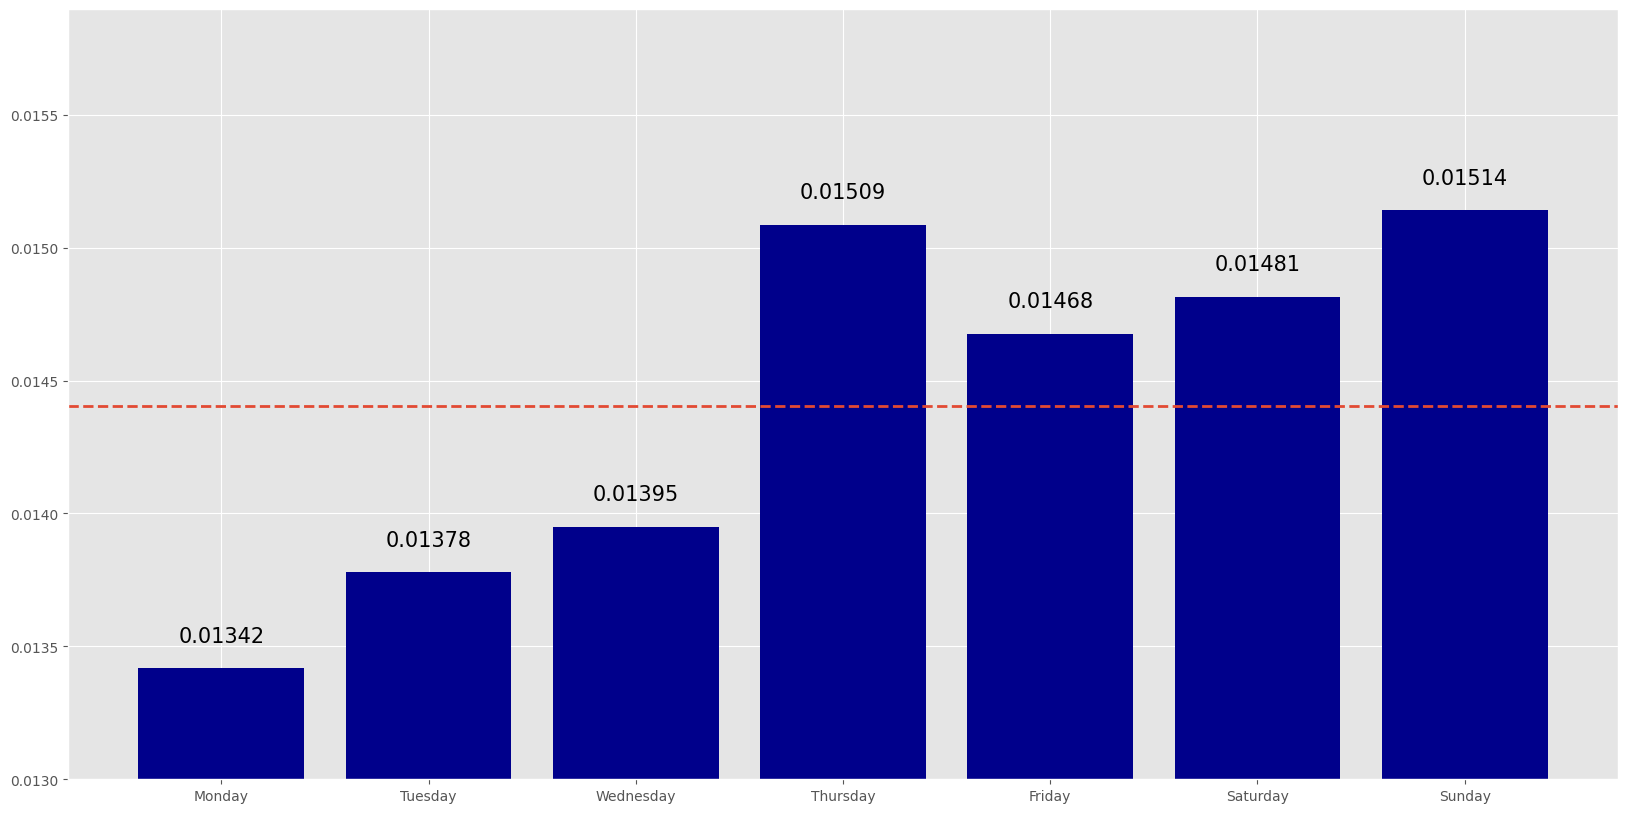

In [13]:
#plot
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_dow,x=y_dow.index,height='fraud_label',color='darkblue')
ax.set_ylim(bottom=.013)
ax.axhline(y=y_avg,ls='--',lw=2)

for i in (y_dow.index):
    ax.text(i,y_dow.loc[i,'fraud_label']+0.0001,round(y_dow.loc[i,'fraud_label'],5),horizontalalignment='center',fontsize=15)
plt.show()

In [14]:
# Make new entities for variables
data['name']=data.firstname+data.lastname
data['fulladdress']=data.address+data.zip5
data['name_dob']=data.name+data.dob
data['name_fulladdress']=data.name+data.address
data['name_homephone']=data.name+data.homephone
data['fulladdress_dob']=data.address+data.dob
data['fulladdress_homephone']=data.address+data.homephone
data['dob_homephone']=data.dob+data.homephone
data['homephone_name_dob']=data.homephone+data.name_dob

In [15]:
data.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dob_dt', 'age_when_apply', 'dow',
       'dow_risk', 'name', 'fulladdress', 'name_dob', 'name_fulladdress',
       'name_homephone', 'fulladdress_dob', 'fulladdress_homephone',
       'dob_homephone', 'homephone_name_dob'],
      dtype='object')

In [16]:
for i in list(data.iloc[:,np.r_[3:9,14:17]]):
    data['ssn_'+i]=data.ssn+data[i]

In [17]:
data.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dob_dt', 'age_when_apply', 'dow',
       'dow_risk', 'name', 'fulladdress', 'name_dob', 'name_fulladdress',
       'name_homephone', 'fulladdress_dob', 'fulladdress_homephone',
       'dob_homephone', 'homephone_name_dob', 'ssn_firstname', 'ssn_lastname',
       'ssn_address', 'ssn_zip5', 'ssn_dob', 'ssn_homephone', 'ssn_name',
       'ssn_fulladdress', 'ssn_name_dob'],
      dtype='object')

In [18]:
attributes=list(data.iloc[:,np.r_[2, 5, 6, 7, 8, 14:32]].columns)

In [19]:
attributes

['ssn',
 'address',
 'zip5',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob']

In [20]:
len(attributes)

23

# Creating Variables

In [21]:
df=data.copy()
vars=data.copy()
df['check_date']=df.date
df['check_record']=df.record
numvars = 1
vars.shape

(1000000, 32)

## Velocity/counts and days since

In [22]:
begin=time.time()
for i in attributes:
    st=time.time()
    df_1=df[['record','date',i]]
    df_r=df[['check_record','check_date',i]]
    temp=pd.merge(df_1,df_r,left_on=i,right_on=i)
    
    #day since
    day_since_df=temp[temp.record>temp.check_record][['record','date','check_date']]\
    .groupby('record')[['date','check_date']].last()
    mapper=(day_since_df.date-day_since_df.check_date).dt.days
    vars[i+'_day_since']=vars.record.map(mapper)
    vars[i+'_day_since'].fillna(365,inplace=True)
    print(f'\n{i}_day_since --->Done')
    
    #Velocity
    for v in [0,1,3,7,14,30]:
        count_day_df=temp[((temp.check_date)>=(temp.date-dt.timedelta(v)))
                          &(temp.record>=temp.check_record)]
        col_name=f'{i}_count_{v}'
        mapper2=count_day_df.groupby('record')[i].count()
        vars[col_name]=vars.record.map(mapper2)
        print(f'{i}_count_{str(v)} --->Done')
    print(f'Run time for entity {i}--------{time.time()-st:0.2f}s')
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')


ssn_day_since --->Done
ssn_count_0 --->Done
ssn_count_1 --->Done
ssn_count_3 --->Done
ssn_count_7 --->Done
ssn_count_14 --->Done
ssn_count_30 --->Done
Run time for entity ssn--------1.42s

address_day_since --->Done
address_count_0 --->Done
address_count_1 --->Done
address_count_3 --->Done
address_count_7 --->Done
address_count_14 --->Done
address_count_30 --->Done
Run time for entity address--------1.47s

zip5_day_since --->Done
zip5_count_0 --->Done
zip5_count_1 --->Done
zip5_count_3 --->Done
zip5_count_7 --->Done
zip5_count_14 --->Done
zip5_count_30 --->Done
Run time for entity zip5--------19.13s

dob_day_since --->Done
dob_count_0 --->Done
dob_count_1 --->Done
dob_count_3 --->Done
dob_count_7 --->Done
dob_count_14 --->Done
dob_count_30 --->Done
Run time for entity dob--------10.51s

homephone_day_since --->Done
homephone_count_0 --->Done
homephone_count_1 --->Done
homephone_count_3 --->Done
homephone_count_7 --->Done
homephone_count_14 --->Done
homephone_count_30 --->Done
Run time

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


homephone_name_dob_count_30 --->Done
Run time for entity homephone_name_dob--------1.38s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_firstname_day_since --->Done
ssn_firstname_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_firstname_count_1 --->Done
ssn_firstname_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_firstname_count_7 --->Done
ssn_firstname_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_firstname_count_30 --->Done
Run time for entity ssn_firstname--------1.42s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_lastname_day_since --->Done
ssn_lastname_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_lastname_count_1 --->Done
ssn_lastname_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_lastname_count_7 --->Done
ssn_lastname_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_lastname_count_30 --->Done
Run time for entity ssn_lastname--------1.43s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_address_day_since --->Done
ssn_address_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_address_count_1 --->Done
ssn_address_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_address_count_7 --->Done
ssn_address_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_address_count_30 --->Done
Run time for entity ssn_address--------1.39s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_zip5_day_since --->Done
ssn_zip5_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_zip5_count_1 --->Done
ssn_zip5_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_zip5_count_7 --->Done
ssn_zip5_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_zip5_count_30 --->Done
Run time for entity ssn_zip5--------1.35s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_dob_day_since --->Done
ssn_dob_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_dob_count_1 --->Done
ssn_dob_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_dob_count_7 --->Done
ssn_dob_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_dob_count_30 --->Done
Run time for entity ssn_dob--------1.35s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_homephone_day_since --->Done
ssn_homephone_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_homephone_count_1 --->Done
ssn_homephone_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_homephone_count_7 --->Done
ssn_homephone_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_homephone_count_30 --->Done
Run time for entity ssn_homephone--------1.31s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_name_day_since --->Done
ssn_name_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_name_count_1 --->Done
ssn_name_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_name_count_7 --->Done
ssn_name_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_name_count_30 --->Done
Run time for entity ssn_name--------1.43s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_fulladdress_day_since --->Done
ssn_fulladdress_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_fulladdress_count_1 --->Done
ssn_fulladdress_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_fulladdress_count_7 --->Done
ssn_fulladdress_count_14 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_fulladdress_count_30 --->Done
Run time for entity ssn_fulladdress--------1.36s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_day_since']=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)



ssn_name_dob_day_since --->Done
ssn_name_dob_count_0 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_name_dob_count_1 --->Done
ssn_name_dob_count_3 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


ssn_name_dob_count_7 --->Done
ssn_name_dob_count_14 --->Done
ssn_name_dob_count_30 --->Done
Run time for entity ssn_name_dob--------1.38s
Total run time:1.09min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/2314681417.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper2)


In [23]:
numvars_new = len(vars.columns)- 31 - numvars
numvars = len(vars.columns) - 31
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 161   total variables: 162


In [24]:
# relative velocity
start=time.time()
for i in attributes:
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
            vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
print(f'Total run time:{time.time()-start:0.2f}s')

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataF

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataF

Total run time:0.35s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[i+'_count_'+d+'_by_'+dd]=vars[i + '_count_' + d]/(vars[i+'_count_'+dd]/float(dd))
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/4002286599.py:6: PerformanceWarning: DataF

In [25]:
numvars_new = len(vars.columns) - 31 - numvars
numvars = len(vars.columns) - 31
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 184   total variables: 346


## Counts by entities 

In [26]:
# this cell makes twice as many variables as needed. It makes each variable twice because of the loop logic. 
# It would be nice to fix this.
# If anybody ever fixes this cell please send me an email.
begin=time.time()
for i in attributes:
    for v in attributes:
        st=time.time()
        if i==v:
            continue
        else:
            df_c=df[['record','date',i]]
            df_d=df[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
        
        #number of unique for particular field
        for t in[0,1,3,7,14,30,60]:
            count_day_df=temp[((temp.check_date)>=(temp.date-dt.timedelta(t)))
                          &(temp.record>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['record'])[v].nunique()
            vars[col_name]=vars.record.map(mapper)
        
        print(f'Run time for entity {i} in field {v}--------{time.time()-st:0.2f}s')
        
    print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field address--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field zip5--------2.99s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field dob--------2.95s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field homephone--------2.96s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field name--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field fulladdress--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field name_dob--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field name_fulladdress--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field name_homephone--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field fulladdress_dob--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field fulladdress_homephone--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field dob_homephone--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field homephone_name_dob--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_firstname--------2.47s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_lastname--------2.48s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_address--------2.55s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_zip5--------2.46s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_dob--------2.48s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_homephone--------2.54s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_name--------2.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_fulladdress--------2.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn in field ssn_name_dob--------2.76s
Total run time:0.99min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field zip5--------3.11s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field dob--------3.12s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field homephone--------3.17s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field name--------3.07s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field fulladdress--------2.60s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field name_dob--------2.91s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field name_fulladdress--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field name_homephone--------2.88s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field fulladdress_dob--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field fulladdress_homephone--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field dob_homephone--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field homephone_name_dob--------2.98s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_firstname--------2.98s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_lastname--------3.25s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_address--------3.29s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_zip5--------2.91s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_dob--------2.92s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_homephone--------3.16s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_name--------3.06s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_fulladdress--------3.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity address in field ssn_name_dob--------3.16s
Total run time:2.08min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn--------32.84s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field address--------33.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field dob--------43.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field homephone--------43.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field name--------34.87s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field fulladdress--------32.53s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field name_dob--------33.33s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field name_fulladdress--------32.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field name_homephone--------33.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field fulladdress_dob--------33.05s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field fulladdress_homephone--------32.92s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field dob_homephone--------32.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field homephone_name_dob--------33.40s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_firstname--------32.29s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_lastname--------32.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_address--------31.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_zip5--------31.51s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_dob--------33.56s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_homephone--------32.23s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_name--------33.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_fulladdress--------31.90s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity zip5 in field ssn_name_dob--------32.57s
Total run time:14.47min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn--------16.52s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field address--------15.52s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field zip5--------18.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field homephone--------17.35s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field name--------16.45s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field fulladdress--------16.01s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field name_dob--------15.89s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field name_fulladdress--------15.96s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field name_homephone--------17.13s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field fulladdress_dob--------15.50s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field fulladdress_homephone--------16.38s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field dob_homephone--------15.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field homephone_name_dob--------16.09s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_firstname--------15.94s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_lastname--------15.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_address--------15.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_zip5--------15.49s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_dob--------16.22s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_homephone--------15.89s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_name--------16.26s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_fulladdress--------16.87s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob in field ssn_name_dob--------16.82s
Total run time:20.45min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn--------13.24s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field address--------13.48s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field zip5--------17.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field dob--------15.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field name--------14.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field fulladdress--------13.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field name_dob--------13.54s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field name_fulladdress--------13.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field name_homephone--------13.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field fulladdress_dob--------13.49s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field fulladdress_homephone--------13.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field dob_homephone--------13.07s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field homephone_name_dob--------13.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_firstname--------13.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_lastname--------13.42s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_address--------13.38s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_zip5--------13.10s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_dob--------13.47s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_homephone--------13.25s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_name--------13.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_fulladdress--------14.41s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone in field ssn_name_dob--------14.04s
Total run time:25.53min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn--------3.55s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field address--------3.55s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field zip5--------3.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field dob--------3.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field homephone--------3.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field fulladdress--------3.52s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field name_dob--------3.42s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field name_fulladdress--------3.50s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field name_homephone--------3.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field fulladdress_dob--------3.46s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field fulladdress_homephone--------3.50s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field dob_homephone--------3.45s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field homephone_name_dob--------3.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_firstname--------3.40s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_lastname--------3.41s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_address--------3.45s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_zip5--------3.33s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_dob--------3.39s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_homephone--------3.48s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_name--------3.48s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_fulladdress--------3.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name in field ssn_name_dob--------3.62s
Total run time:26.83min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field address--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field zip5--------3.25s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field dob--------3.28s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field homephone--------3.14s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field name--------2.94s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field name_dob--------2.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field name_fulladdress--------2.90s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field name_homephone--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field fulladdress_dob--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field fulladdress_homephone--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field dob_homephone--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field homephone_name_dob--------3.10s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_firstname--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_lastname--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_address--------2.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_zip5--------2.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_dob--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_homephone--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_name--------2.86s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_fulladdress--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress in field ssn_name_dob--------2.99s
Total run time:27.87min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn--------2.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field address--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field zip5--------3.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field dob--------2.99s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field homephone--------3.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field name--------2.86s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field fulladdress--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field name_fulladdress--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field name_homephone--------2.96s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field fulladdress_dob--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field fulladdress_homephone--------2.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field dob_homephone--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field homephone_name_dob--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_firstname--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_lastname--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_address--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_zip5--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_dob--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_homephone--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_name--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_fulladdress--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_dob in field ssn_name_dob--------2.71s
Total run time:28.88min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn--------2.53s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field address--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field zip5--------3.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field dob--------2.97s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field homephone--------3.01s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field name--------2.88s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field fulladdress--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field name_dob--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field name_homephone--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field fulladdress_dob--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field fulladdress_homephone--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field dob_homephone--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field homephone_name_dob--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_firstname--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_lastname--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_address--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_zip5--------2.53s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_dob--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_homephone--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_name--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_fulladdress--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_fulladdress in field ssn_name_dob--------2.89s
Total run time:29.88min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn--------2.55s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field address--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field zip5--------3.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field dob--------2.96s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field homephone--------3.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field name--------2.84s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field fulladdress--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field name_dob--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field name_fulladdress--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field fulladdress_dob--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field fulladdress_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field dob_homephone--------2.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field homephone_name_dob--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_firstname--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_lastname--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_address--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_zip5--------2.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_dob--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_homephone--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_name--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_fulladdress--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity name_homephone in field ssn_name_dob--------2.89s
Total run time:30.89min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn--------2.55s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field address--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field zip5--------3.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field dob--------2.91s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field homephone--------2.98s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field name--------2.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field fulladdress--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field name_dob--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field name_fulladdress--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field name_homephone--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field fulladdress_homephone--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field dob_homephone--------2.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field homephone_name_dob--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_firstname--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_lastname--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_address--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_zip5--------2.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_dob--------2.56s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_homephone--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_name--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_fulladdress--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_dob in field ssn_name_dob--------2.83s
Total run time:31.89min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field address--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field zip5--------3.07s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field dob--------3.01s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field homephone--------3.06s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field name--------2.91s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field fulladdress--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field name_dob--------2.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field name_fulladdress--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field name_homephone--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field fulladdress_dob--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field dob_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field homephone_name_dob--------2.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_firstname--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_lastname--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_address--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_zip5--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_dob--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_homephone--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_name--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_fulladdress--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity fulladdress_homephone in field ssn_name_dob--------2.96s
Total run time:32.91min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn--------2.52s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field address--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field zip5--------2.96s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field dob--------2.90s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field homephone--------2.95s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field name--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field fulladdress--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field name_dob--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field name_fulladdress--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field name_homephone--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field fulladdress_dob--------2.60s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field fulladdress_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field homephone_name_dob--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_firstname--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_lastname--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_address--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_zip5--------2.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_dob--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_homephone--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_name--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_fulladdress--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity dob_homephone in field ssn_name_dob--------2.83s
Total run time:33.91min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn--------2.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field address--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field zip5--------3.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field dob--------2.97s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field homephone--------2.97s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field name--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field fulladdress--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field name_dob--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field name_fulladdress--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field name_homephone--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field fulladdress_dob--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field fulladdress_homephone--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field dob_homephone--------2.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_firstname--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_lastname--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_address--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_zip5--------2.60s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_dob--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_name--------2.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_fulladdress--------2.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity homephone_name_dob in field ssn_name_dob--------2.86s
Total run time:34.92min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field address--------2.82s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field zip5--------3.04s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field dob--------3.07s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field homephone--------3.06s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field name--------2.90s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field fulladdress--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field name_dob--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field name_fulladdress--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field name_homephone--------2.90s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field fulladdress_dob--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field fulladdress_homephone--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field dob_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field homephone_name_dob--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_lastname--------2.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_address--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_zip5--------2.56s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_dob--------2.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_homephone--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_name--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_fulladdress--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_firstname in field ssn_name_dob--------2.84s
Total run time:35.94min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn--------2.53s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field address--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field zip5--------3.05s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field dob--------3.05s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field homephone--------3.05s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field name--------2.89s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field fulladdress--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field name_dob--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field name_fulladdress--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field name_homephone--------2.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field fulladdress_dob--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field fulladdress_homephone--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field dob_homephone--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field homephone_name_dob--------2.94s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_firstname--------2.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_address--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_zip5--------2.54s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_dob--------2.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_name--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_fulladdress--------2.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_lastname in field ssn_name_dob--------2.81s
Total run time:36.95min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn--------2.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field address--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field zip5--------3.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field dob--------2.99s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field homephone--------3.01s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field name--------2.88s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field fulladdress--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field name_dob--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field name_fulladdress--------2.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field name_homephone--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field fulladdress_dob--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field fulladdress_homephone--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field dob_homephone--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field homephone_name_dob--------2.86s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_firstname--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_lastname--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_zip5--------2.53s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_dob--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_name--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_fulladdress--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_address in field ssn_name_dob--------2.91s
Total run time:37.96min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field address--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field zip5--------3.07s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field dob--------2.97s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field homephone--------3.03s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field name--------2.86s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field fulladdress--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field name_dob--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field name_fulladdress--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field name_homephone--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field fulladdress_dob--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field fulladdress_homephone--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field dob_homephone--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field homephone_name_dob--------2.84s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_firstname--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_lastname--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_address--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_dob--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_homephone--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_name--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_fulladdress--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_zip5 in field ssn_name_dob--------2.88s
Total run time:38.97min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field address--------2.86s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field zip5--------2.98s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field dob--------2.97s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field homephone--------3.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field name--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field fulladdress--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field name_dob--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field name_fulladdress--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field name_homephone--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field fulladdress_dob--------2.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field fulladdress_homephone--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field dob_homephone--------2.59s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field homephone_name_dob--------2.95s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_firstname--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_lastname--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_address--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_zip5--------2.60s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_homephone--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_name--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_fulladdress--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_dob in field ssn_name_dob--------2.75s
Total run time:39.99min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn--------2.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field address--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field zip5--------2.98s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field dob--------2.94s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field homephone--------2.98s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field name--------2.84s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field fulladdress--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field name_dob--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field name_fulladdress--------2.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field name_homephone--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field fulladdress_dob--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field fulladdress_homephone--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field dob_homephone--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field homephone_name_dob--------2.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_firstname--------2.62s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_lastname--------2.63s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_address--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_zip5--------2.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_dob--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_name--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_fulladdress--------2.81s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_homephone in field ssn_name_dob--------2.92s
Total run time:40.99min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn--------2.60s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field address--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field zip5--------3.09s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field dob--------3.13s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field homephone--------3.21s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field name--------2.91s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field fulladdress--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field name_dob--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field name_fulladdress--------2.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field name_homephone--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field fulladdress_dob--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field fulladdress_homephone--------2.93s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field dob_homephone--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field homephone_name_dob--------2.90s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_firstname--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_lastname--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_address--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_zip5--------2.57s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_dob--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_homephone--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_fulladdress--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name in field ssn_name_dob--------2.89s
Total run time:42.02min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn--------2.54s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field address--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field zip5--------3.01s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field dob--------3.03s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field homephone--------3.05s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field name--------2.87s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field fulladdress--------2.71s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field name_dob--------2.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field name_fulladdress--------2.76s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field name_homephone--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field fulladdress_dob--------2.78s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field fulladdress_homephone--------2.77s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field dob_homephone--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field homephone_name_dob--------2.84s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_firstname--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_lastname--------2.64s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_address--------2.61s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_zip5--------2.53s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_dob--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_homephone--------2.70s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_name--------2.83s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_fulladdress in field ssn_name_dob--------2.98s
Total run time:43.03min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field address--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field zip5--------3.03s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field dob--------3.00s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field homephone--------3.02s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field name--------2.88s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field fulladdress--------2.74s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field name_dob--------2.69s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field name_fulladdress--------2.84s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field name_homephone--------2.80s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field fulladdress_dob--------2.66s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field fulladdress_homephone--------2.79s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field dob_homephone--------2.65s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field homephone_name_dob--------2.85s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_firstname--------2.72s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_lastname--------2.68s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_address--------2.75s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_zip5--------2.67s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_dob--------2.58s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_homephone--------2.73s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_name--------2.91s


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

Run time for entity ssn_name_dob in field ssn_fulladdress--------2.86s
Total run time:44.05min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/613680335.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)


In [27]:
del df

In [28]:
numvars_new = len(vars.columns) - 31 - numvars
numvars = len(vars.columns) - 31
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 3542   total variables: 3888


In [29]:
print('time to here: ',dt.datetime.now() - start_time)

time to here:  0:45:15.589902


In [30]:
# # This works to remove duplicate columns from a very large dataframe, but it takes a long time
# # for a df shape 1,000,000 by 4,000 it takes 10 hours on my macbook

# def duplicate_columns(frame):
#     groups = frame.columns.to_series().groupby(frame.dtypes).groups
#     dups = []

#     for t, v in groups.items():

#         cs = frame[v].columns
#         vs = frame[v]
#         lcs = len(cs)

#         for i in range(lcs):
#             ia = vs.iloc[:,i].values
#             for j in range(i+1, lcs):
#                 ja = vs.iloc[:,j].values
#                 if np.array_equiv(ia, ja):
#                     dups.append(cs[i])
#                     break

#     return dups

In [31]:
# %%time
# # I need this extra column dedup cell for my smaller memory macbook, but it takes about 10 hours to run
# dups = duplicate_columns(vars)
# vars = vars.drop(dups, axis=1)
# numvars = len(vars.columns) - 31
# vars.shape

In [32]:
# %%time
# print(vars.shape)
# vars_new = vars.T.drop_duplicates(inplace=True).T
# del(vars)
# vars = vars_new.copy()
# del(vars_new)
# vars.shape

## Maximum Indicator

In [33]:
# # Maximum Indicator
# begin=time.time()
# for i in attributes:
#     print(i)
#     for v in ['1','3','7','30']:
#         st=time.time()
#         mapper=vars.groupby(i)[i+'_count_'+v].max()
#         vars['max_count_by_'+i+'_'+v]=vars[i].map(mapper)
#         print(f'max_count_by_{i}_{v} --->Done')
#     print(f'Run time for entity {i}--------{time.time()-st}s')
# print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

In [34]:
numvars_new = len(vars.columns) - 31 - numvars
numvars = len(vars.columns) - 31
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 0   total variables: 3888


## Age Indicator

In [35]:
# Age Indicator
data['age_when_apply']=data['date'].dt.year-data['dob_dt'].dt.year
begin=time.time()
for i in attributes:
    st=time.time()
    mapper_max=vars.groupby(i)['age_when_apply'].max()
    mapper_mean=vars.groupby(i)['age_when_apply'].mean()
    mapper_min=vars.groupby(i)['age_when_apply'].min()
    vars['max_age_by_'+i]=vars[i].map(mapper_max)
    vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
    vars['min_age_by_'+i]=vars[i].map(mapper_min)
    print(f'age_by_{i} --->Done')
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_address --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['min_age_by_'+i]=vars[i].map(mapper_min)


age_by_zip5 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_dob --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_homephone --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_name --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_fulladdress --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_name_dob --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_name_fulladdress --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_name_homephone --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_fulladdress_dob --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_fulladdress_homephone --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_dob_homephone --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_homephone_name_dob --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_firstname --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_lastname --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_address --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_zip5 --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_dob --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_homephone --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_name --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

age_by_ssn_fulladdress --->Done


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['max_age_by_'+i]=vars[i].map(mapper_max)
/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['mean_age_by_'+i]=vars[i].map(mapper_mean)


age_by_ssn_name_dob --->Done
Total run time:0.85min


/var/folders/xx/xzxtm5cd4_qc7z_7jjysft080000gn/T/ipykernel_2775/865726071.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars['min_age_by_'+i]=vars[i].map(mapper_min)


In [36]:
del data

In [37]:
vars.shape

(1000000, 3988)

In [38]:
numvars_new = len(vars.columns) - 31 - numvars
numvars = len(vars.columns) - 31
print("new variables:",numvars_new,"  total variables:",numvars)

new variables: 69   total variables: 3957


In [39]:
vars.columns.to_list()
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')

Total run time:0.86min


In [40]:
vars.shape

(1000000, 3988)

In [41]:
print('duration: ',dt.datetime.now() - start_time)

duration:  0:46:07.020459


In [42]:
vars.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,...,min_age_by_ssn_homephone,max_age_by_ssn_name,mean_age_by_ssn_name,min_age_by_ssn_name,max_age_by_ssn_fulladdress,mean_age_by_ssn_fulladdress,min_age_by_ssn_fulladdress,max_age_by_ssn_name_dob,mean_age_by_ssn_name_dob,min_age_by_ssn_name_dob
0,1,2017-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0,...,110,110,110.0,110,110,110.0,110,110,110.0,110
1,2,2017-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,...,83,83,83.0,83,83,83.0,83,83,83.0,83
2,3,2017-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,...,110,110,110.0,110,110,110.0,110,110,110.0,110
3,4,2017-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,...,73,73,73.0,73,73,73.0,73,73,73.0,73
4,5,2017-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,...,19,19,19.0,19,19,19.0,19,19,19.0,19


In [43]:
%%time
vars.drop(columns=attributes,inplace=True)
vars.head()

CPU times: user 4.31 s, sys: 6.05 s, total: 10.4 s
Wall time: 16.4 s


,record,date,firstname,lastname,fraud_label,dob_dt,age_when_apply,dow,dow_risk,ssn_day_since,...,min_age_by_ssn_homephone,max_age_by_ssn_name,mean_age_by_ssn_name,min_age_by_ssn_name,max_age_by_ssn_fulladdress,mean_age_by_ssn_fulladdress,min_age_by_ssn_fulladdress,max_age_by_ssn_name_dob,mean_age_by_ssn_name_dob,min_age_by_ssn_name_dob
0,1,2017-01-01,XRRAMMTR,SMJETJMJ,0,1907-06-26,110,Sunday,0.01514,365.0,...,110,110,110.0,110,110,110.0,110,110,110.0,110
1,2,2017-01-01,MAMSTUJR,RTTEMRRR,1,1934-06-15,83,Sunday,0.01514,365.0,...,83,83,83.0,83,83,83.0,83,83,83.0,83
2,3,2017-01-01,SZMMUJEZS,EUSEZRAE,0,1907-06-26,110,Sunday,0.01514,365.0,...,110,110,110.0,110,110,110.0,110,110,110.0,110
3,4,2017-01-01,SJJZSXRSZ,ETJXTXXS,0,1944-04-30,73,Sunday,0.01514,365.0,...,73,73,73.0,73,73,73.0,73,73,73.0,73
4,5,2017-01-01,SSSXUEJMS,SSUUJXUZ,0,1998-03-15,19,Sunday,0.01514,365.0,...,19,19,19.0,19,19,19.0,19,19,19.0,19


In [44]:
%%time
vars.drop(columns=['date','firstname','lastname','dob_dt','dow'],inplace=True)
vars.head()

CPU times: user 4.29 s, sys: 5.94 s, total: 10.2 s
Wall time: 16.6 s


,record,fraud_label,age_when_apply,dow_risk,ssn_day_since,ssn_count_0,ssn_count_1,ssn_count_3,ssn_count_7,ssn_count_14,...,min_age_by_ssn_homephone,max_age_by_ssn_name,mean_age_by_ssn_name,min_age_by_ssn_name,max_age_by_ssn_fulladdress,mean_age_by_ssn_fulladdress,min_age_by_ssn_fulladdress,max_age_by_ssn_name_dob,mean_age_by_ssn_name_dob,min_age_by_ssn_name_dob
0,1,0,110,0.01514,365.0,1,1,1,1,1,...,110,110,110.0,110,110,110.0,110,110,110.0,110
1,2,1,83,0.01514,365.0,1,1,1,1,1,...,83,83,83.0,83,83,83.0,83,83,83.0,83
2,3,0,110,0.01514,365.0,1,1,1,1,1,...,110,110,110.0,110,110,110.0,110,110,110.0,110
3,4,0,73,0.01514,365.0,1,1,1,1,1,...,73,73,73.0,73,73,73.0,73,73,73.0,73
4,5,0,19,0.01514,365.0,1,1,1,1,1,...,19,19,19.0,19,19,19.0,19,19,19.0,19


In [45]:
vars.shape

(1000000, 3960)

In [47]:
%%time
vars.to_csv('vars before dedup.csv',index=False)

CPU times: user 18min 10s, sys: 22 s, total: 18min 32s
Wall time: 18min 37s


In [48]:
print('duration: ',dt.datetime.now() - start_time)


duration:  1:05:17.934831
